### Finetuning pretrained resnet-34 model with progressive resizing and discriminative learning



###### Name: Hemanth Pasupuleti

##### Download Data

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz

--2021-04-24 15:36:45--  https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.2.35
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.2.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345236087 (329M) [application/x-tar]
Saving to: ‘oxford-102-flowers.tgz’

oxford-102-flowers. 100%[===================>] 329.24M  62.8MB/s    in 5.5s    

2021-04-24 15:36:51 (60.0 MB/s) - ‘oxford-102-flowers.tgz’ saved [345236087/345236087]



In [ ]:
!tar -xvzf oxford-102-flowers.tgz   #Extract the data

Streaming output truncated to the last 5000 lines.
oxford-102-flowers/jpg/image_07751.jpg
oxford-102-flowers/jpg/image_07634.jpg
oxford-102-flowers/jpg/image_01310.jpg
oxford-102-flowers/jpg/image_03097.jpg
oxford-102-flowers/jpg/image_05968.jpg
oxford-102-flowers/jpg/image_00448.jpg
oxford-102-flowers/jpg/image_07792.jpg
oxford-102-flowers/jpg/image_07265.jpg
oxford-102-flowers/jpg/image_03343.jpg
oxford-102-flowers/jpg/image_00210.jpg
oxford-102-flowers/jpg/image_03833.jpg
oxford-102-flowers/jpg/image_03993.jpg
oxford-102-flowers/jpg/image_02316.jpg
oxford-102-flowers/jpg/image_02991.jpg
oxford-102-flowers/jpg/image_06135.jpg
oxford-102-flowers/jpg/image_05413.jpg
oxford-102-flowers/jpg/image_04386.jpg
oxford-102-flowers/jpg/image_01073.jpg
oxford-102-flowers/jpg/image_06546.jpg
oxford-102-flowers/jpg/image_01521.jpg
oxford-102-flowers/jpg/image_03887.jpg
oxford-102-flowers/jpg/image_00149.jpg
oxford-102-flowers/jpg/image_00921.jpg
oxford-102-flowers/jpg/image_02386.jpg
oxford-102-fl

In [ ]:
%cd oxford-102-flowers

/content/oxford-102-flowers


In [ ]:


import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
train_df = pd.read_csv('train.txt', delimiter = " ",header=None)
train_df = train_df.to_numpy()
print(train_df.shape)

(1020, 2)


In [ ]:
val_df = pd.read_csv('valid.txt', delimiter = " ",header=None)
val_df = val_df.to_numpy()
print(val_df.shape)

(1020, 2)


In [ ]:
test_df = pd.read_csv('test.txt', delimiter = " ",header=None)
test_df = test_df.to_numpy()
print(test_df.shape)

(6149, 2)


In [ ]:
# Define image loader
def pil_loader(path,types="RGB"):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
          if types== 'RGB':
            return img.convert(types)

In [ ]:
# Custom dataset model

class Dataset(torch.utils.data.Dataset):
  def __init__(self,root,path,loader,transforms=None):
    self.root = root
    self.path = path
    self.loader = loader
    self.transforms = transforms

  def __getitem__(self, index):
    name,label = self.path[index]
    img = self.loader(self.root+name)
    if transforms:
      img = self.transforms(img)

    return img,label

  def __len__(self):
    return len(self.path)

In [ ]:
#Load data

def load_data(batch_size,resize,crop,test=0,normalize=1):
  stats = ((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)) #ImageNet stats
  test_trans = [
              transforms.Resize(resize),
              transforms.CenterCrop(crop),
              transforms.ToTensor(),
              transforms.Normalize(*stats)
          ]
  if test == 0:
    train_transform = transforms.Compose([
              transforms.RandomRotation(30),
              transforms.RandomResizedCrop(crop),
              transforms.RandomVerticalFlip(),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(*stats)
          ])
    
    val_transform = transforms.Compose(test_trans)
    #Load Dataset
    trainDS = Dataset(root='',path=train_df,loader=pil_loader,transforms=train_transform)
    valDS = Dataset(root='',path=val_df,loader=pil_loader,transforms=val_transform)
            
    #dataset Loaders
    train_loader = DataLoader(trainDS, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valDS, batch_size=batch_size, shuffle=True)
    
    return (train_loader,val_loader)

  elif test == 1:
    if normalize == 0:
      test_trans = test_trans[0:-1]
    test_transform = transforms.Compose(test_trans)
    testDS = Dataset(root='',path=test_df,loader=pil_loader,transforms=test_transform)
    test_loader = DataLoader(testDS, batch_size=batch_size, shuffle=True)
    return test_loader




  

In [ ]:
# lets visualize some images
data_loader = load_data(16,256,224,test=1,normalize=0)


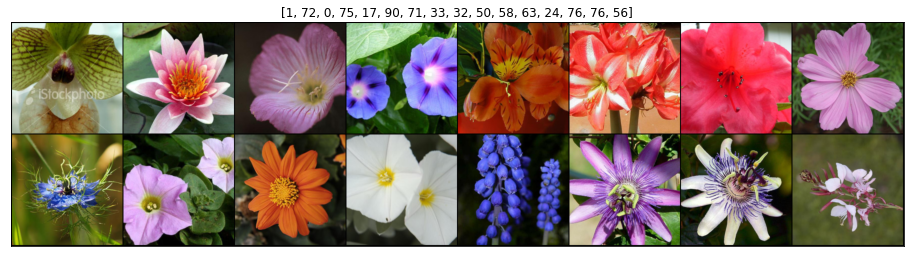

In [ ]:
def show_batch(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        ax.set_title([x.item() for x in labels])
        break
        
show_batch(data_loader)

In [ ]:
#Calculate accuracy 
def accuracy(predicted,actual):
    _, predictions = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [ ]:
# To increase LR rate exponentially
class ExponentialLR(_LRScheduler):
    def __init__(self,optimizer,end_lr,num_iter,last_epoch=-1):
        self.num_iter = num_iter
        self.end_lr = end_lr
        super(ExponentialLR, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        r = self.last_epoch / (self.num_iter - 1)
        
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [ ]:
# Learning rate finder
def find_lr(optimizer,resize_dim,crop_dim,batch_size=128,end_lr=10,num_epochs=10):
    '''
    input:
      optimizer: optimizer with which you want to optimize
      resize_dim: list of dimensions to which you want to resize
      crop_dim: list of dimensions to which you want to crop
            crop_dim: center crops the resized image in val/test
                      RandomResizedCrop for training
      num_epochs: number of epochs you want to train
      batch_size: batch size of the training dataset
      end_lr = the learning rate where you want to end

    output:
      train_loss: training data loss
      val_loss: validation data loss
      train_acc: training accuracy 
      val_acc: validation accuracy
      lrrates: learning rate over the epochs
    '''


    print("------- Training on image dim: ",crop_dim,"------------" )
    lr_scheduler = ExponentialLR(optimizer,end_lr=end_lr,num_iter=num_epochs)
    
    train_loader,val_loader = load_data(batch_size,resize_dim,crop_dim)

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    lrrates = []
    
    
    
    for epoch in range(num_epochs):
      ep_acc = 0.0
      ep_loss = 0.0
      for i,batch in enumerate(train_loader):
        img,label = batch
        img = Variable(img.type(Tensor))
        label = Variable(label).to(device)
        out = model(img)
        loss = criterion(out,label)
        ep_loss += loss.item()
        ep_acc += accuracy(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("epoch: ",epoch," loss: ",loss)
      ep_loss = ep_loss/(i+1)
      ep_acc = ep_acc/(i+1)
      lr_scheduler.step()
      lrrates.append(lr_scheduler.get_last_lr()[0])

      train_loss.append(ep_loss)
      train_acc.append(ep_acc)

      print("EPOCH: ",epoch," loss: ",ep_loss," accuracy: ",ep_acc)

      with torch.no_grad():
        ep_acc = 0.0
        ep_loss = 0.0
        for i,batch in enumerate(val_loader):
          img,label = batch
          img = Variable(img.type(Tensor))
          label = Variable(label).to(device)
          out = model(img)
          loss = criterion(out,label)
          ep_loss += loss.item()
          ep_acc += accuracy(out,label)

        ep_acc = ep_acc/(i+1)
        ep_loss = ep_loss/(i+1)
        val_loss.append(ep_loss)
        val_acc.append(ep_acc)
        print("Epoch:",epoch,"Validation Loss:",ep_loss," Accuracy:",ep_acc)

    return train_loss,val_loss,train_acc,val_acc,lrrates

In [ ]:
# Let us see total number of classes in the model
num_classes = len(np.unique(train_df[:,1]))
print("Total number of classes: ",num_classes)

Total number of classes:  102


In [ ]:
#Define the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
    
    def forward(self,X):
        return self.network(X)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model = Model().to(device)

In [ ]:
#Define the criterion
criterion = nn.CrossEntropyLoss()
criterion.to(device)


CrossEntropyLoss()

In [ ]:
#Defince optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-8,betas=[0.9,0.999],weight_decay=1e-1)

In [ ]:
t_loss,v_loss,t_acc,v_acc,lrs = find_lr(optimizer,256,224,num_epochs=20)

------- Training on image dim:  224 ------------
epoch:  0  loss:  tensor(4.8296, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.8953, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.9675, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.9005, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.8382, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.7901, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.7876, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.9226, device='cuda:0', grad_fn=<NllLossBackward>)
EPOCH:  0  loss:  4.866429567337036  accuracy:  tensor(0.0068)
Epoch: 0 Validation Loss: 4.851709544658661  Accuracy: tensor(0.0108)
epoch:  1  loss:  tensor(4.7960, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(4.8946, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(4.8575, device='cuda:0'

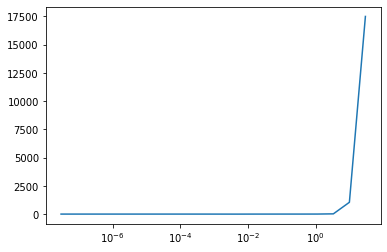

In [ ]:
plt.plot(lrs,t_loss)
plt.xscale('log')

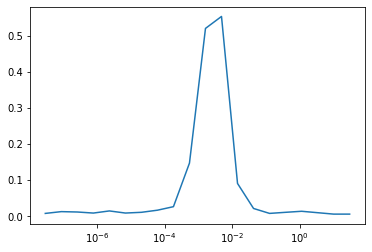

In [ ]:
plt.plot(lrs,t_acc)
plt.xscale("log")

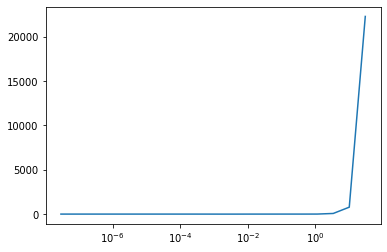

In [ ]:
plt.plot(lrs,v_loss)
plt.xscale('log')

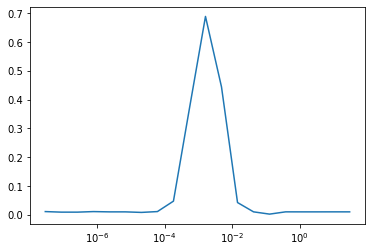

In [ ]:
plt.plot(lrs,v_acc)
plt.xscale('log')

##### From the above graphs it can be seen that the good learning rate was near 1e-3

In [ ]:
def train(model,resize_dim,crop_dim,max_lrs,num_epochs=20,batch_size=64,weight_decay=1e-1,useScheduler=False,FreezeParam = True,UnFreeze=True,base_lrs=[],lr_rate=1e-4):
    ''' 
    input:
      model: the model you want to train
      resize_dim: list of dimensions to which you want to resize
      crop_dim: list of dimensions to which you want to crop
            crop_dim: center crops the resized image in val/test
                      RandomResizedCrop for training
      num_epochs: number of epochs you want to train
      batch_size: batch size of the training dataset
      weight_decay: the amount of regularization you want to add
      useScheduler: If True it uses One Cycle Learning rate scheduler
      FreezeParam: Freezes the entire model except the fc layer
      UnFreeze: If yes it unfreezes 
      max_lrs: (list or float) max value for the One cycle learning
      base_lrs: (list) of values should be of length 6 for discriminative learning
      lr_rate: default learning rate for optimizer

    output:
      train_loss: list of training losses for each dimension data
      val_loss: list of validation losses for each dimension data
      train_acc: list of training accuracies for each dimension data
      val_acc: list of validation accuracies for each dimension data
      lrs: learning rates over the epochs for each dimension data   

    '''
    
    
    
    
    
    if len(crop_dim) == 0:
      print("Crop Dimensions were null...")
      return None
    if len(resize_dim) != len(crop_dim):
      print("RESIZE AND CROP DIMENSIONS SHOULD BE SAME...")
      return None
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    lrs = []
    
    
    for dimInd in range(len(crop_dim)):
        print("---- Training with image dim",crop_dim[dimInd],"--------")

        #get data loaders
        train_loader,val_loader = load_data(batch_size,resize_dim[dimInd],crop_dim[dimInd])

        
        if FreezeParam:
            print("FREEEZINGG.....")
            model.freeze()
        else:
            print("UNFREEZING.....")
            model.unfreeze()
        #optimizer

        #group parameters for discriminative learning
        grouped_parameters = [
        {"params": model.network.conv1.parameters(), 'lr': lr_rate},
       {"params": model.network.layer1.parameters(), 'lr': lr_rate},
       {"params": model.network.layer2.parameters(), 'lr': lr_rate},
       {"params": model.network.layer3.parameters(), 'lr': lr_rate},
       {"params": model.network.layer4.parameters(), 'lr': lr_rate},
       {"params": model.network.fc.parameters(), 'lr': lr_rate},
        ]
        optimizer = torch.optim.Adam(grouped_parameters,lr=lr_rate,betas=[0.9,0.99],weight_decay=weight_decay) 

        if len(base_lrs) == len(optimizer.param_groups):
            print("Using discriminative learning rates...")
            for param_groups,lr in zip(optimizer.param_groups,base_lrs):
                param_groups['lr'] = lr 
        
        if useScheduler:
            print("Using scheduler....")
#             scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs,verbose = True)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=max_lrs,
                                                            total_steps=num_epochs*round(len(train_loader.dataset)/batch_size))
        
        t_loss = []
        v_loss = []
        t_acc = []
        v_acc = []
        lrrates = []
        
        
        for epoch in range(num_epochs):
          ep_acc = 0.0
          ep_loss = 0.0
          if UnFreeze and epoch==num_epochs//2:
              print("....UNFREEZING....")
              model.unfreeze()
          for i,batch in enumerate(train_loader):
            
            img,label = batch
            img = Variable(img.type(Tensor))
            label = Variable(label).to(device)
            out = model(img)
            loss = criterion(out,label)
            ep_loss += loss.item()
            ep_acc += accuracy(out,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if useScheduler:
                scheduler.step()
                lrrates.append(scheduler.get_last_lr()[0])
            print("epoch: ",epoch," loss: ",loss)
            
          ep_loss = ep_loss/(i+1)
          ep_acc = ep_acc/(i+1)


          t_loss.append(ep_loss)
          t_acc.append(ep_acc)


            


          print("EPOCH: ",epoch," loss: ",ep_loss," accuracy: ",ep_acc)

          with torch.no_grad():
            ep_acc = 0.0
            ep_loss = 0.0
            for i,batch in enumerate(val_loader):
              img,label = batch
              img = Variable(img.type(Tensor))
              label = Variable(label).to(device)
              out = model(img)
              loss = criterion(out,label)
              ep_loss += loss.item()
              ep_acc += accuracy(out,label)

            ep_acc = ep_acc/(i+1)
            ep_loss = ep_loss/(i+1)
            v_loss.append(ep_loss)
            v_acc.append(ep_acc)
            print("Epoch:",epoch,"Validation Loss:",ep_loss," Accuracy:",ep_acc)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        lrs.append(lrrates)
    
    return train_loss,val_loss,train_acc,val_acc,lrs   
        
        
        
        

In [ ]:
def test(model,resize_dims,crop_dims,batch_size=64):
    '''
    input:
      model: the model you want to test 
      resize_dims: list of dimensions to which you want to resize
      crop_dims: list of dimensions to which you want to crop
            crop_dim: center crops the resized image in val/test
      num_epochs: number of epochs you want to train
      batch_size: batch size of the training dataset

    '''

    for dimInd in range(len(crop_dims)):
        print('-----Testing for dim: ',crop_dims[dimInd],"-------")
        test_loader = load_data(batch_size,resize_dims[dimInd],crop_dims[dimInd],test=1)
        
        with torch.no_grad():
            ep_acc = 0.0
            ep_loss = 0.0
            for i,batch in enumerate(test_loader):
                img,label = batch
                img = Variable(img.type(Tensor))
                label = Variable(label).to(device)
                out = model(img)
                loss = criterion(out,label)
                ep_loss += loss.item()
                ep_acc += accuracy(out,label)
            ep_acc = ep_acc/(i+1)
            ep_loss = ep_loss/(i+1)
            print("For dimension:",crop_dims[dimInd],"Test Loss:",ep_loss," Accuracy:",ep_acc)
        
        
        
        
        

#### Training model with progressive resizing and discriminative learning

In [ ]:
prog_model = Model().to(device)

In [ ]:
num_layers = 6
base_lrs = [1e-8,1e-8,1e-6,1e-6,1e-5,1e-5]
resize_dim = [64,128,256]
crop_dim = [56,112,224]

lrs = [1e-3]
for i in range(1,num_layers):
  lrs.append(lrs[i-1]/5)

lrs = lrs[::-1]
print(lrs)


[3.2000000000000006e-07, 1.6000000000000004e-06, 8.000000000000001e-06, 4e-05, 0.0002, 0.001]


In [ ]:
train_losses,val_losses,train_accs,val_accs,optlrs = train(prog_model,num_epochs=6,batch_size=256,max_lrs=lrs,base_lrs=base_lrs,FreezeParam=True,UnFreeze=True,useScheduler=True,resize_dim=resize_dim,crop_dim=crop_dim)

---- Training with image dim 56 --------
FREEEZINGG.....
Using discriminative learning rates...
Using scheduler....
epoch:  0  loss:  tensor(4.9947, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(5.0964, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(5.0189, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(4.9520, device='cuda:0', grad_fn=<NllLossBackward>)
EPOCH:  0  loss:  5.01550030708313  accuracy:  tensor(0.0108)
Epoch: 0 Validation Loss: 4.895534992218018  Accuracy: tensor(0.0167)
epoch:  1  loss:  tensor(4.8851, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(4.7902, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(4.6985, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(4.6447, device='cuda:0', grad_fn=<NllLossBackward>)
EPOCH:  1  loss:  4.7546268701553345  accuracy:  tensor(0.0236)
Epoch: 1 Validation Loss: 4.439603090286255  Accuracy: tensor(0.0550)
ep

In [ ]:
len(train_losses)

3

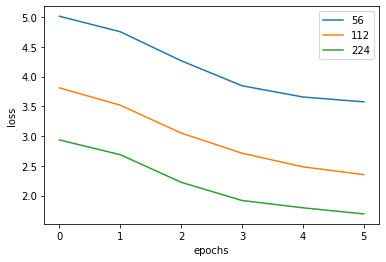

In [ ]:
cropdim = [56,112,224]
for i in range(len(cropdim)):
    plt.plot(train_losses[i],label=cropdim[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


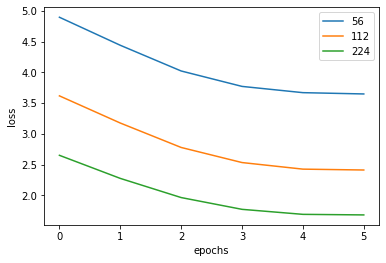

In [ ]:
for i in range(len(cropdim)):
    plt.plot(val_losses[i],label=cropdim[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


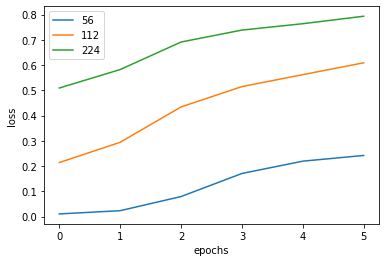

In [ ]:
for i in range(len(cropdim)):
    plt.plot(train_accs[i],label=cropdim[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


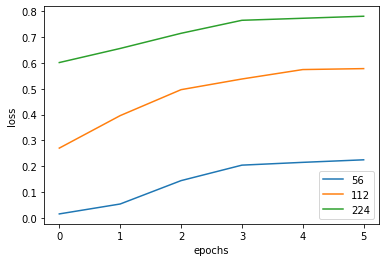

In [ ]:
for i in range(len(cropdim)):
    plt.plot(val_accs[i],label=cropdim[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


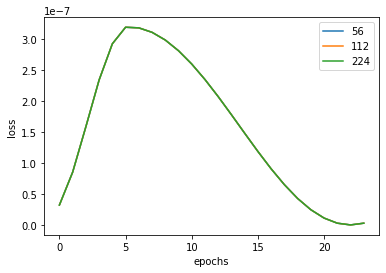

In [ ]:
for i in range(len(cropdim)):
    plt.plot(optlrs[i],label=cropdim[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


In [ ]:
num_layers = 6
base_lrs = [1e-8,1e-8,1e-6,1e-6,1e-5,1e-5]
resize_dim = [256]
crop_dim = [224]

lrs = [1e-3]
for i in range(1,num_layers):
  lrs.append(lrs[i-1]/5)

lrs = lrs[::-1]
print(lrs)

[3.2000000000000006e-07, 1.6000000000000004e-06, 8.000000000000001e-06, 4e-05, 0.0002, 0.001]


In [ ]:
t_losses,v_losses,t_accs,v_accs,opt_lrs = train(prog_model,num_epochs=30,batch_size=256,max_lrs=lrs,base_lrs=base_lrs,FreezeParam=True,UnFreeze=True,useScheduler=True,resize_dim=resize_dim,crop_dim=crop_dim)

---- Training with image dim 224 --------
FREEEZINGG.....
Using discriminative learning rates...
Using scheduler....
epoch:  0  loss:  tensor(1.6962, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(1.5549, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(1.7309, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  loss:  tensor(1.7513, device='cuda:0', grad_fn=<NllLossBackward>)
EPOCH:  0  loss:  1.6833158731460571  accuracy:  tensor(0.7841)
Epoch: 0 Validation Loss: 1.6617753505706787  Accuracy: tensor(0.7804)
epoch:  1  loss:  tensor(1.6152, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(1.7359, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(1.6206, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  loss:  tensor(1.6645, device='cuda:0', grad_fn=<NllLossBackward>)
EPOCH:  1  loss:  1.6590480506420135  accuracy:  tensor(0.8118)
Epoch: 1 Validation Loss: 1.6346529424190521  Accuracy: tensor(0.784

In [ ]:
test(prog_model,[64,128,256],[56,112,224],256)

-----Testing for dim:  56 -------
For dimension: 56 Test Loss: 3.657438850402832  Accuracy: tensor(0.1700)
-----Testing for dim:  112 -------
For dimension: 112 Test Loss: 1.614141640663147  Accuracy: tensor(0.6182)
-----Testing for dim:  224 -------
For dimension: 224 Test Loss: 0.753480474948883  Accuracy: tensor(0.8560)


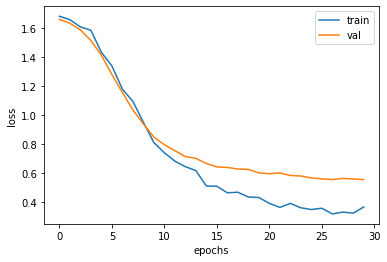

In [ ]:
for i in range(len(t_losses)):
    plt.plot(t_losses[i],label='train')
    plt.plot(v_losses[i],label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


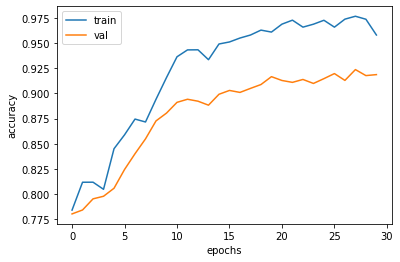

In [ ]:
for i in range(len(t_losses)):
    plt.plot(t_accs[i],label='train')
    plt.plot(v_accs[i],label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
